In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('Sport car price.csv')

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
#finding rows with null values
df[df.isna().any(axis=1)]

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
168,Rimac,C_Two,2022,NaN,1914,1696,1.9,"2,400,000"
171,Tesla,Model S Plaid,2021,NaN,1020,1050,1.98,"131,190"
222,Porsche,Taycan Turbo S,2021,NaN,750,774,2.6,"185,000"
247,Tesla,Model S Plaid,2022,NaN,1020,1050,1.9,"131,190"
387,Rimac,C_Two,2022,NaN,1888,1696,1.8,"2,400,000"
389,Tesla,Roadster,2022,NaN,10000+,0,1.9,"200,000"
642,Tesla,Model S Plaid,2021,Electric,1020,NaN,1.9,"139,990"
686,Rimac,C_Two,2022,NaN,1914,1696,1.85,"2,400,000"
697,Lotus,Evija,2022,NaN,1972,1254,2.5,"2,700,000"
752,Porsche,Taycan,2022,NaN,469,479,3.8,"79,900"


Dropping rows where Engine Size and Torque is NaN.

In [4]:
df=df.dropna(subset=['Engine Size (L)','Torque (lb-ft)'])

Splitting the original Dataframe into 2.
One dataframe will contain all ICE (internal combustion engine) cars and the other dataframe will contain all Electric/Hybrid Cars
For the DecisionTree Regressor model, we will use only ICE cars but with the Classifier model, we will concat the to dataframes together

In [5]:
dfElec = df.loc[df['Engine Size (L)'].str.contains('Electric|Hybrid')]
df = df.loc[~df['Engine Size (L)'].str.contains('Electric|Hybrid')]

replaceing all commas, + and - for easier datatype conversions

In [6]:
df['Horsepower'] = df['Horsepower'].str.replace('[+,-,]', '')
df['Torque (lb-ft)'] = df['Torque (lb-ft)'].str.replace('[+,-,]', '')
df['Price (in USD)'] = df['Price (in USD)'].str.replace('[+,-,]', '')

C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\1704719958.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Horsepower'] = df['Horsepower'].str.replace('[+,-,]', '')
C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\1704719958.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Torque (lb-ft)'] = df['Torque (lb-ft)'].str.replace('[+,-,]', '')
C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\1704719958.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Price (in USD)'] = df['Price (in USD)'].str.replace('[+,-,]', '')


In [7]:
df =df.drop(index=335) #torque value is missing. dropping that row

df.shape



(948, 8)

Changing Datatypes of columns

In [9]:
df = df.astype({'Engine Size (L)':'float','Horsepower': 'int64', 'Torque (lb-ft)': 'int64', '0-60 MPH Time (seconds)': 'float', 'Price (in USD)': 'int64'})

In [10]:
df.dtypes #sanity check

Car Make                    object
Car Model                   object
Year                         int64
Engine Size (L)            float64
Horsepower                   int64
Torque (lb-ft)               int64
0-60 MPH Time (seconds)    float64
Price (in USD)               int64
dtype: object

convert Dollars to $1000s

In [11]:
df['Price (in USD $1000)'] = df['Price (in USD)'] / 1000
df = df.drop(columns='Price (in USD)')

initial data-analysis and visualizations

In [12]:
df[['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)', 'Price (in USD $1000)']].describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD $1000)
count,948.000000,948.000000,948.000000,948.000000,948.000000
mean,4.395781,603.325949,519.694093,3.586920,342.768959
std,1.398801,382.482684,285.783466,0.724134,690.903793
min,0.000000,181.000000,151.000000,1.900000,25.000000
25%,3.500000,454.000000,398.000000,3.000000,70.471250
50%,4.000000,583.000000,505.000000,3.500000,121.750000
75%,5.200000,660.000000,590.000000,4.000000,240.250000
max,8.400000,10000.000000,7376.000000,6.500000,5200.000000


In [13]:
#Drop outlier of horsepower >2000, Torque >2000
indexAge = df[ (df['Horsepower'] > 2000) | (df['Torque (lb-ft)'] > 2000) ].index
df.drop(indexAge , inplace=True)

In [14]:
df.dtypes

Car Make                    object
Car Model                   object
Year                         int64
Engine Size (L)            float64
Horsepower                   int64
Torque (lb-ft)               int64
0-60 MPH Time (seconds)    float64
Price (in USD $1000)       float64
dtype: object

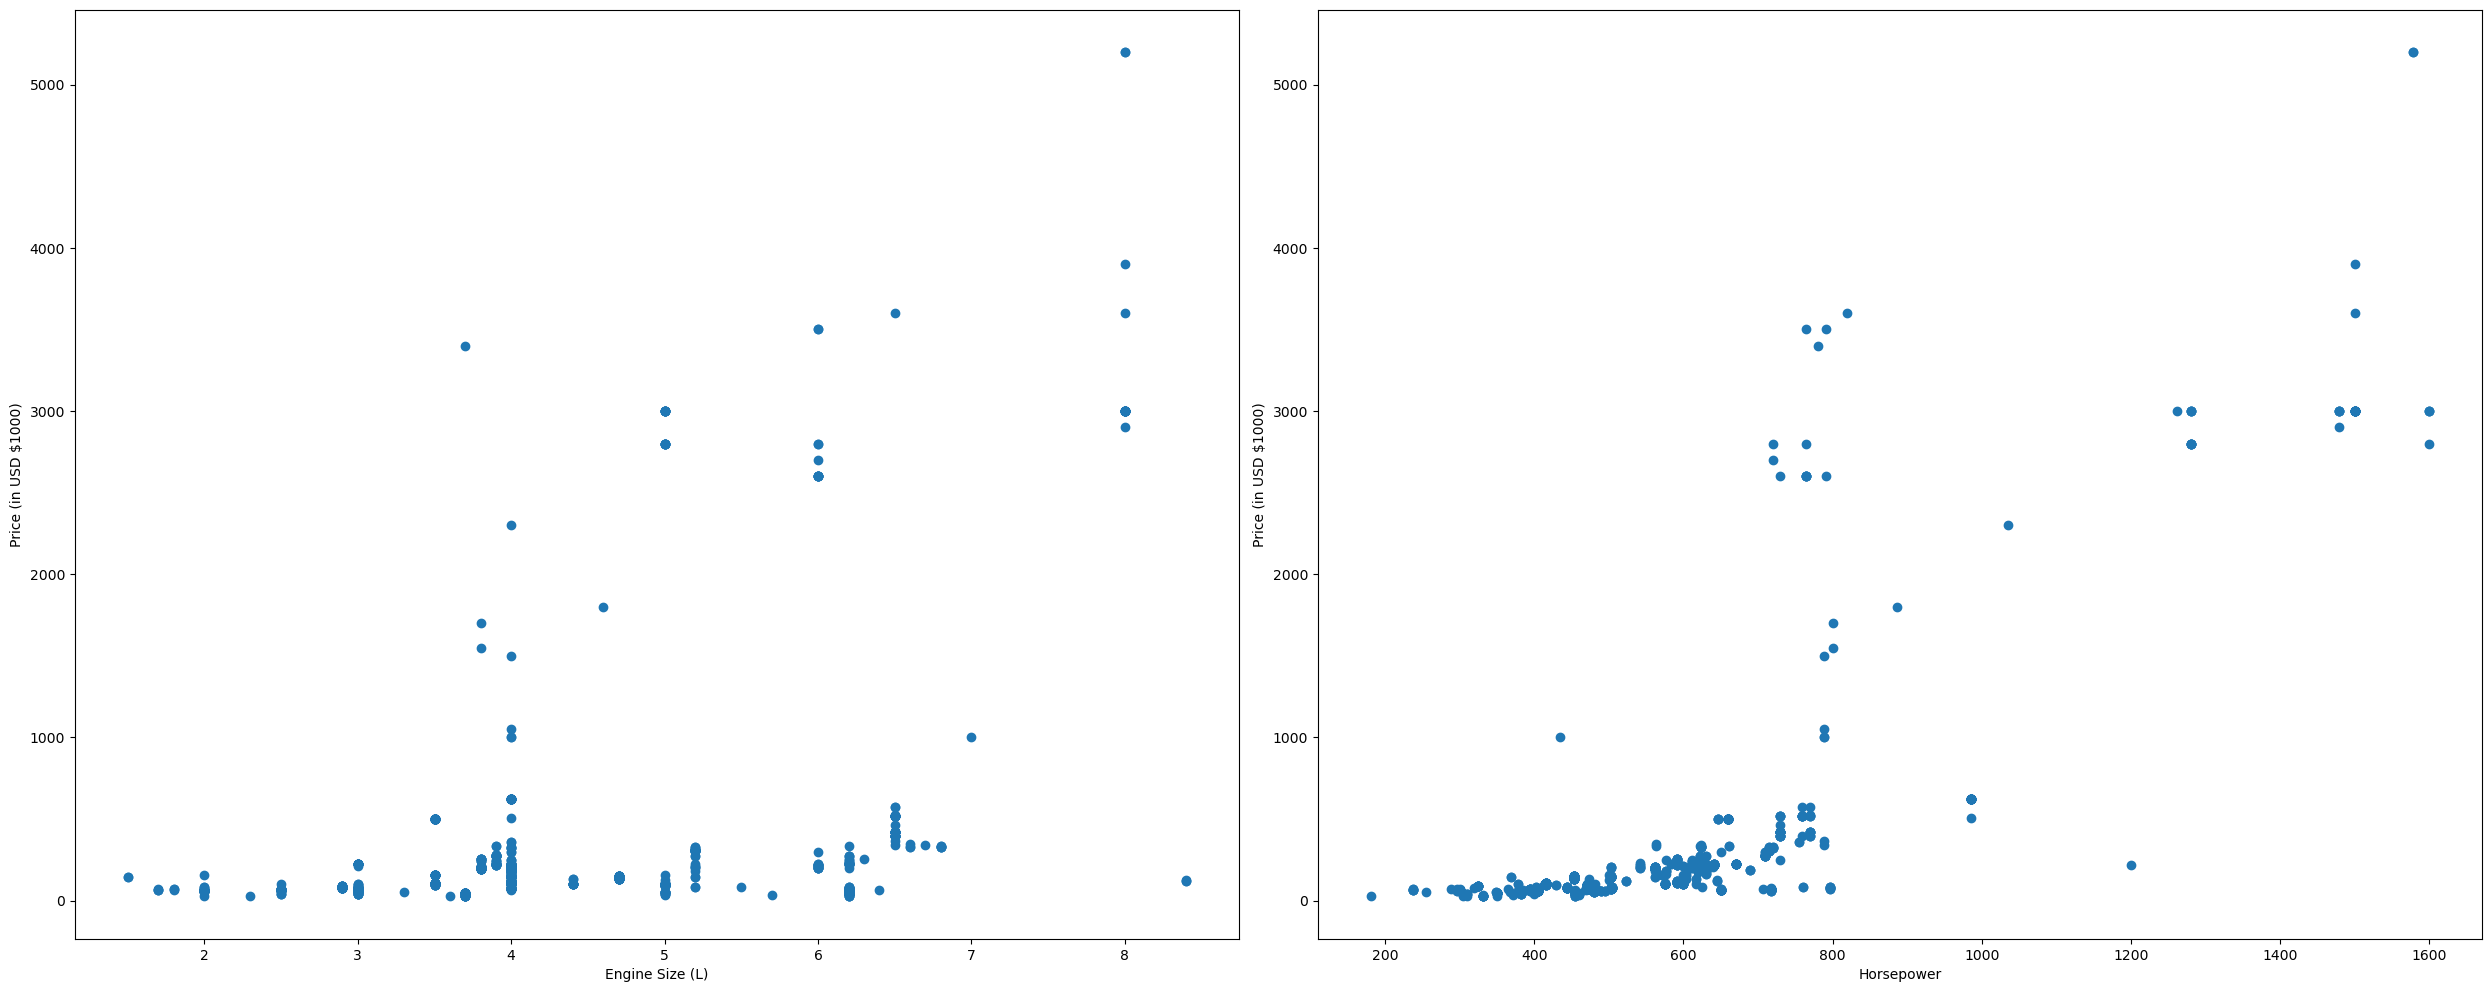

In [15]:
y = df['Price (in USD $1000)']
fig, ax = plt.subplots(1,2, figsize = (25,10))
ax[0].scatter(df['Engine Size (L)'], y)
ax[0].set_xlabel('Engine Size (L)')
ax[0].set_ylabel('Price (in USD $1000)')
ax[1].scatter(df['Horsepower'], y)
ax[1].set_xlabel('Horsepower')
ax[1].set_ylabel('Price (in USD $1000)')

fig.tight_layout(pad=1)
plt.show()

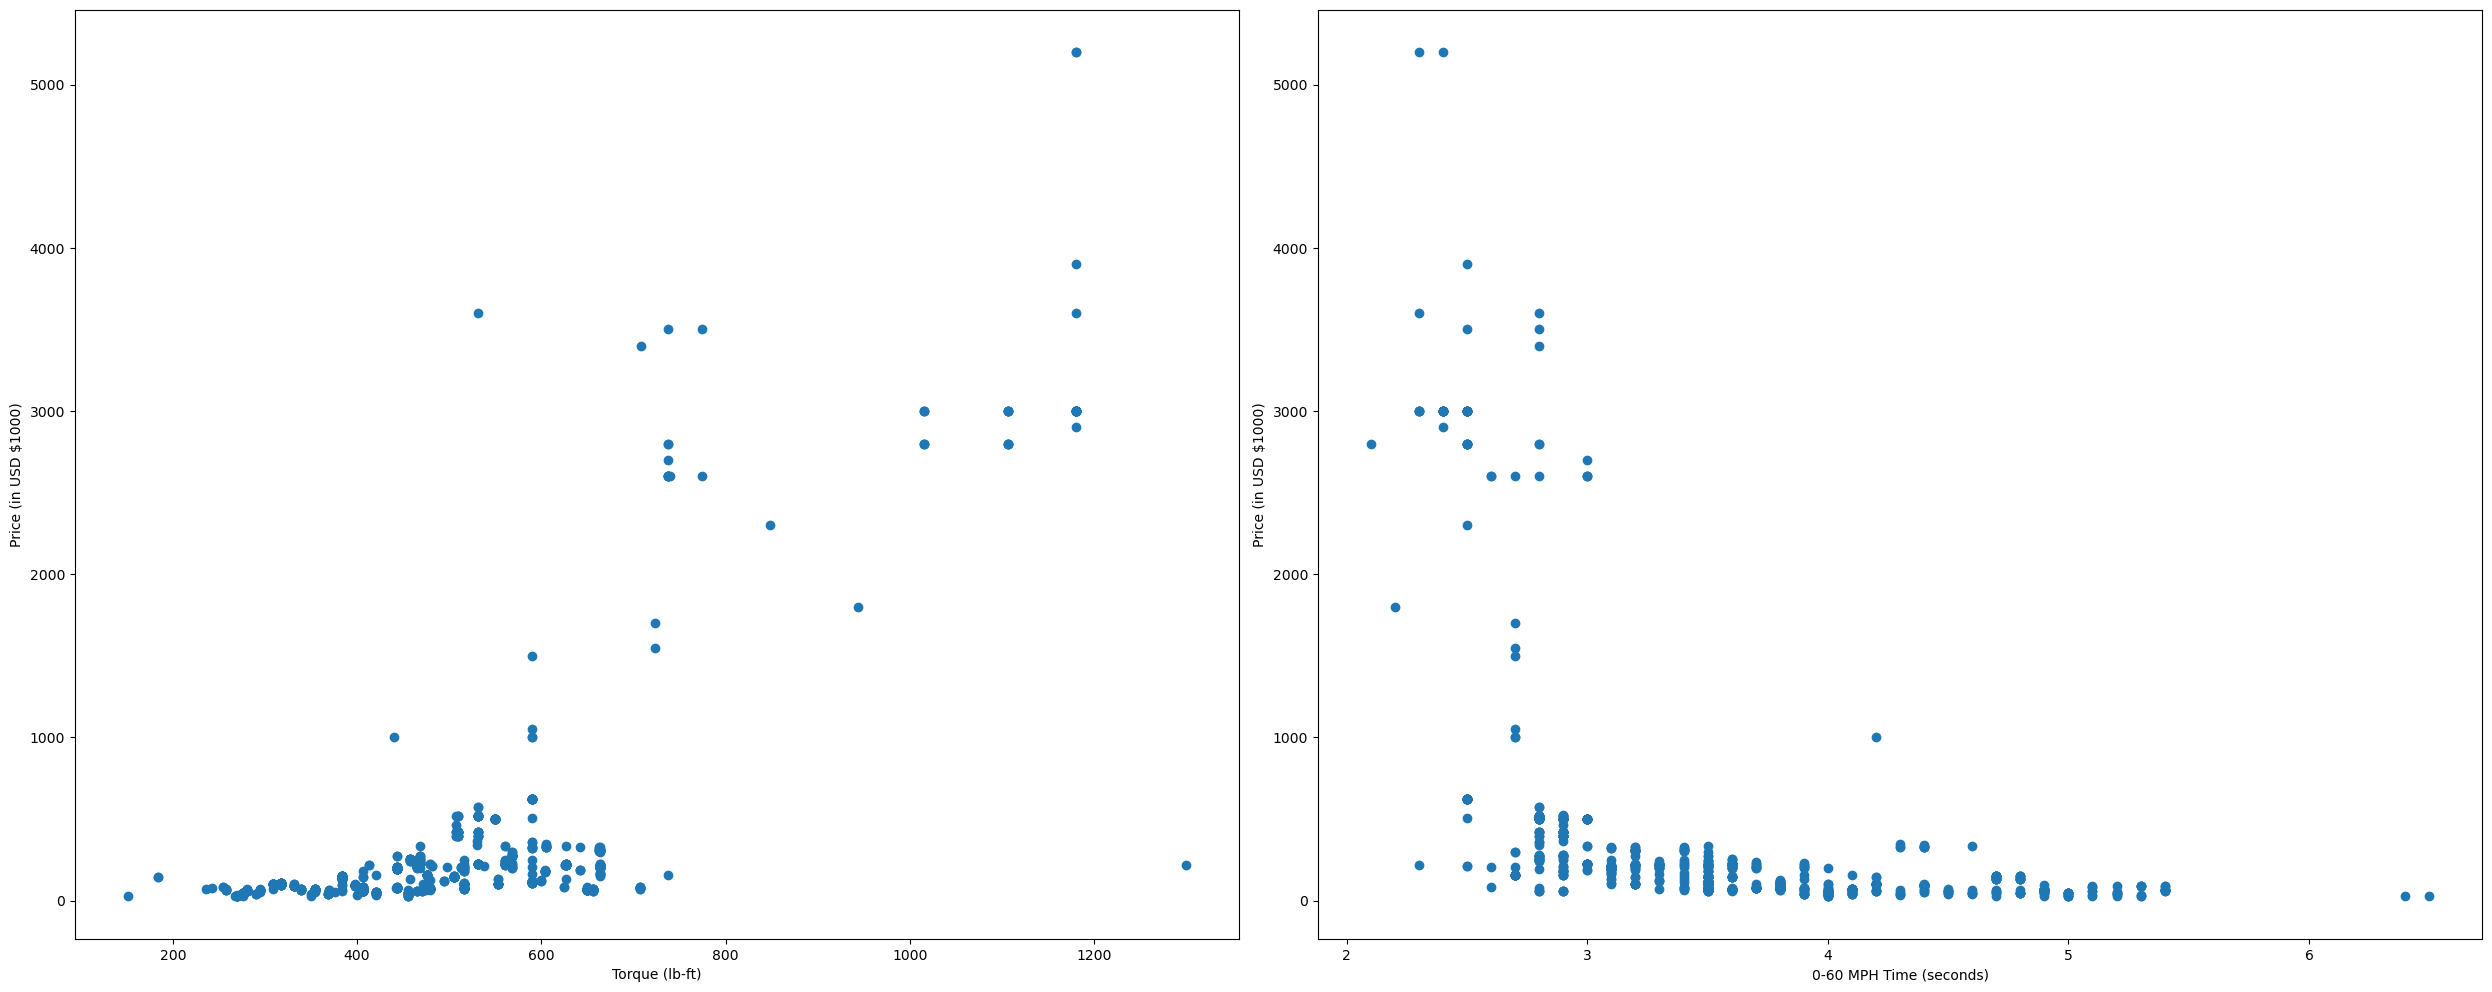

In [16]:
y = df['Price (in USD $1000)']
fig, ax = plt.subplots(1,2, figsize = (25,10))
ax[0].scatter(df['Torque (lb-ft)'], y)
ax[0].set_xlabel('Torque (lb-ft)')
ax[0].set_ylabel('Price (in USD $1000)')
ax[1].scatter(df['0-60 MPH Time (seconds)'], y)
ax[1].set_xlabel('0-60 MPH Time (seconds)')
ax[1].set_ylabel('Price (in USD $1000)')
fig.tight_layout(pad=1)
plt.show()

Decision Tree ML

In [17]:
X_hp= df[['Horsepower']]
y= df['Price (in USD $1000)'] #target/Price
X_train, X_test, y_train, y_test = train_test_split(X_hp,y, random_state=42)

In [18]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((237, 1), (237,), (710, 1), (710,))

In [19]:
regr = DecisionTreeRegressor(random_state=0)
regr.fit(X_train, y_train) #fit the train model
print(f'levels of depth: {regr.get_depth()}')
print(f'Train score: {regr.score(X_train, y_train)}, Test score: {regr.score(X_test, y_test)}')
y_predict = regr.predict(X_test)

levels of depth: 14
Train score: 0.959220370027958, Test score: 0.9699616777835356


In [ ]:
max(X_train['Horsepower']), min(X_train['Horsepower'])

In [21]:
reg_depth_4 = DecisionTreeRegressor(random_state=0, max_depth=4)
reg_depth_4.fit(X_train, y_train)
print(f'levels of depth: {reg_depth_4.get_depth()}')
print(f'Train score: {reg_depth_4.score(X_train, y_train)}, Test score: {reg_depth_4.score(X_test, y_test)}')

levels of depth: 4
Train score: 0.8575209693225125, Test score: 0.909130326422126


C:\Users\jinhe\OneDrive\Documents\Dev10\Anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\jinhe\OneDrive\Documents\Dev10\Anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


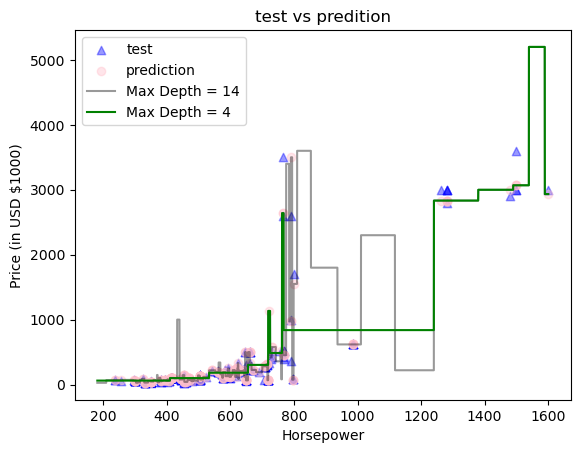

In [22]:
plt.scatter(X_test, y_test, color = 'blue', marker='^', alpha=0.4)
plt.scatter(X_test, y_predict, color = 'pink', marker='o', alpha=0.4)
plt.title('test vs predition')
plt.xlabel('Horsepower')
plt.ylabel('Price (in USD $1000)')
X_grid = np.arange(min(X_hp['Horsepower']), max(X_hp['Horsepower']), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.plot(X_grid, regr.predict(X_grid), color='black', alpha= 0.4)
X_grid1 = np.arange(min(X_hp['Horsepower']), max(X_hp['Horsepower']), 0.01)
X_grid1 = X_grid1.reshape((len(X_grid), 1))
plt.plot(X_grid, reg_depth_4.predict(X_grid), color='green')
plt.legend(['test', 'prediction', f'Max Depth = {regr.get_depth()}', f'Max Depth = {reg_depth_4.get_depth()}'])
plt.show()

levels of depth: 11
Train score: 0.6078693562518598 ,Test score: 0.47404218268526377


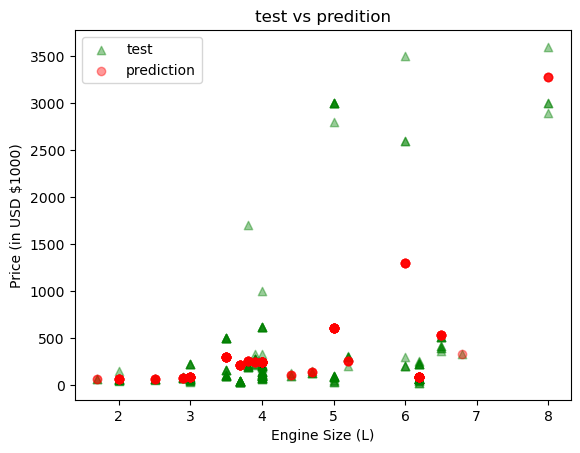

In [23]:
X_es= df[['Engine Size (L)']] #features
X_train, X_test, y_train, y_test = train_test_split(X_es,y, random_state=42)
regr2 = DecisionTreeRegressor(random_state=0)
regr2.fit(X_train, y_train) #fit the train model
print(f'levels of depth: {regr2.get_depth()}')
print(f'Train score: {regr2.score(X_train, y_train)} ,Test score: {regr2.score(X_test, y_test)}')
y_predict2 = regr2.predict(X_test)
plt.scatter(X_test, y_test, color = 'green', marker='^', alpha=0.4)
plt.scatter(X_test, y_predict2, color = 'red', marker='o', alpha=0.4)
plt.title('test vs predition')
plt.xlabel('Engine Size (L)')
plt.ylabel('Price (in USD $1000)')
plt.legend(['test', 'prediction'])
# X_grid = np.arange(min(X_es['Engine Size (L)']), max(X_es['Engine Size (L)']), 0.01)
# X_grid = X_grid.reshape((len(X_grid), 1))
# plt.plot(X_grid, regr2.predict(X_grid), color='black', alpha= 0.4)
plt.show()

levels of depth: 11
Train score: 0.9278118742659195 ,Test score: 0.9045724964553818


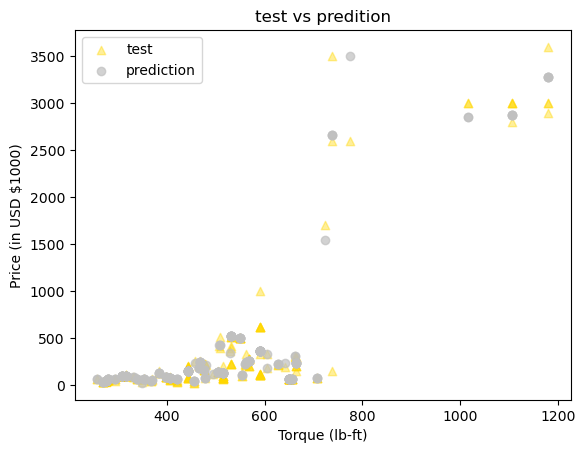

In [24]:
X_tq= df[['Torque (lb-ft)']] #features
X_train, X_test, y_train, y_test = train_test_split(X_tq,y, random_state=42)
regr3 = DecisionTreeRegressor(random_state=0)
regr3.fit(X_train, y_train) #fit the train model
print(f'levels of depth: {regr3.get_depth()}')
print(f'Train score: {regr3.score(X_train, y_train)} ,Test score: {regr3.score(X_test, y_test)}')
y_predict3 = regr3.predict(X_test)
plt.scatter(X_test, y_test, color = 'gold', marker='^', alpha=0.4)
plt.scatter(X_test, y_predict3, color = 'silver', marker='o', alpha=0.7)
plt.title('test vs predition')
plt.xlabel('Torque (lb-ft)')
plt.ylabel('Price (in USD $1000)')
plt.legend(['test', 'prediction'])
# X_grid = np.arange(min(X_tq['Torque (lb-ft)']), max(X_tq['Torque (lb-ft)']), 0.01)
# X_grid = X_grid.reshape((len(X_grid), 1))
# plt.plot(X_grid, regr3.predict(X_grid), color='black', alpha= 0.4)
plt.show()

levels of depth: 10
Train score: 0.6408858682423868 ,Test score: 0.6370827957649522


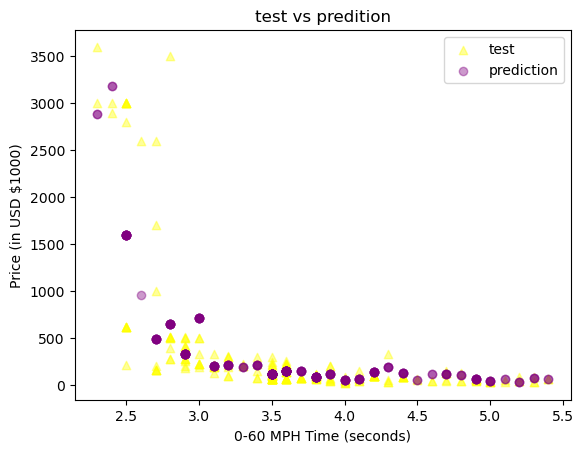

In [25]:
X_zero= df[['0-60 MPH Time (seconds)']] #features
X_train, X_test, y_train, y_test = train_test_split(X_zero,y, random_state=42)
regr4 = DecisionTreeRegressor(random_state=0)
regr4.fit(X_train, y_train) #fit the train model
print(f'levels of depth: {regr4.get_depth()}')
print(f'Train score: {regr4.score(X_train, y_train)} ,Test score: {regr4.score(X_test, y_test)}')
y_predict4 = regr4.predict(X_test)
plt.scatter(X_test, y_test, color = 'yellow', marker='^', alpha=0.4)
plt.scatter(X_test, y_predict4, color = 'purple', marker='o', alpha=0.4)
plt.title('test vs predition')
plt.xlabel('0-60 MPH Time (seconds)')
plt.ylabel('Price (in USD $1000)')
plt.legend(['test', 'prediction'])
# X_grid = np.arange(min(X_zero['Torque (lb-ft)']), max(X_zero['Torque (lb-ft)']), 0.01)
# X_grid = X_grid.reshape((len(X_grid), 1))
# plt.plot(X_grid, regr3.predict(X_grid), color='black', alpha= 0.4)
plt.show()

Decision Tree to predict electric/hybrid/ice cars based on features???

In [26]:
dfElec['Horsepower'] = dfElec['Horsepower'].str.replace('[+,-,]', '')
dfElec['Torque (lb-ft)'] = dfElec['Torque (lb-ft)'].str.replace('[+,-,]', '')
dfElec['Price (in USD)'] = dfElec['Price (in USD)'].str.replace('[+,-,]', '')
dfElec['0-60 MPH Time (seconds)'] = dfElec['0-60 MPH Time (seconds)'].str.replace('< ', '')
dfElec = dfElec.astype({'Horsepower': 'int64', 'Torque (lb-ft)': 'int64', '0-60 MPH Time (seconds)': 'float', 'Price (in USD)': 'int64'})
indexAge = dfElec[ (df['Horsepower'] > 2000) | (dfElec['Torque (lb-ft)'] > 2000) ].index
dfElec.drop(indexAge , inplace=True)
dfElec['Price (in USD $1000)'] = dfElec['Price (in USD)'] / 1000
dfElec = dfElec.drop(columns='Price (in USD)')

C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\3368448371.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dfElec['Horsepower'] = dfElec['Horsepower'].str.replace('[+,-,]', '')
C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\3368448371.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dfElec['Torque (lb-ft)'] = dfElec['Torque (lb-ft)'].str.replace('[+,-,]', '')
C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\3368448371.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dfElec['Price (in USD)'] = dfElec['Price (in USD)'].str.replace('[+,-,]', '')
C:\Users\jinhe\AppData\Local\Temp\ipykernel_48416\3368448371.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  indexAge = dfElec[ (df['Horsepower'] > 2000) | (dfElec['Torque (lb-ft)'] > 2000) ].index


In [29]:
dfElec.loc[dfElec['Engine Size (L)'].str.contains('Electric'), 'Engine Size (L)'] = 'Electric/Hybrid'
dfElec.loc[dfElec['Engine Size (L)'].str.contains('Hybrid'), 'Engine Size (L)'] = 'Electric/Hybrid'

In [30]:
#concat both dataframs
cars_df = pd.concat([df, dfElec])

In [31]:
cars_df['Engine Size (L)'] = cars_df['Engine Size (L)'].astype(str)

In [32]:
cars_df.loc[~cars_df['Engine Size (L)'].str.contains('Electric|Hybrid'), 'Engine Size (L)'] = 'ICE'
cars_df['Engine Size (L)'].value_counts()

ICE                947
Electric/Hybrid     46
Name: Engine Size (L), dtype: int64

using Classification DTree to predict if a car is ICE or Electric/Hybrid.

In [33]:
y1 = cars_df['Engine Size (L)'] #whether it is ICE or electric/hybrid
X1 = cars_df.drop(['Engine Size (L)', 'Car Make', 'Car Model', 'Year'], axis=1) #features

In [34]:
clsmod = DecisionTreeClassifier(random_state=0, criterion='gini')
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)
clsmod.fit(X1_train, y1_train)

DecisionTreeClassifier(random_state=0)

In [35]:
print(f'levels of depth: {clsmod.get_depth()}')
print(f'Train score: {clsmod.score(X1_train, y1_train)} ,Test score: {clsmod.score(X1_test, y1_test)}')
y1_predic_engine = clsmod.predict(X1_test)
from sklearn.metrics import accuracy_score
print(f'Accuracy : {accuracy_score(y1_test,y1_predic_engine)}')

levels of depth: 10
Train score: 0.9986559139784946 ,Test score: 0.9919678714859438
Accuracy : 0.9919678714859438


In [36]:
print(f'value: [# of {clsmod.classes_[0]}, # of {clsmod.classes_[1]}] in each node')

value: [# of Electric/Hybrid, # of ICE] in each node


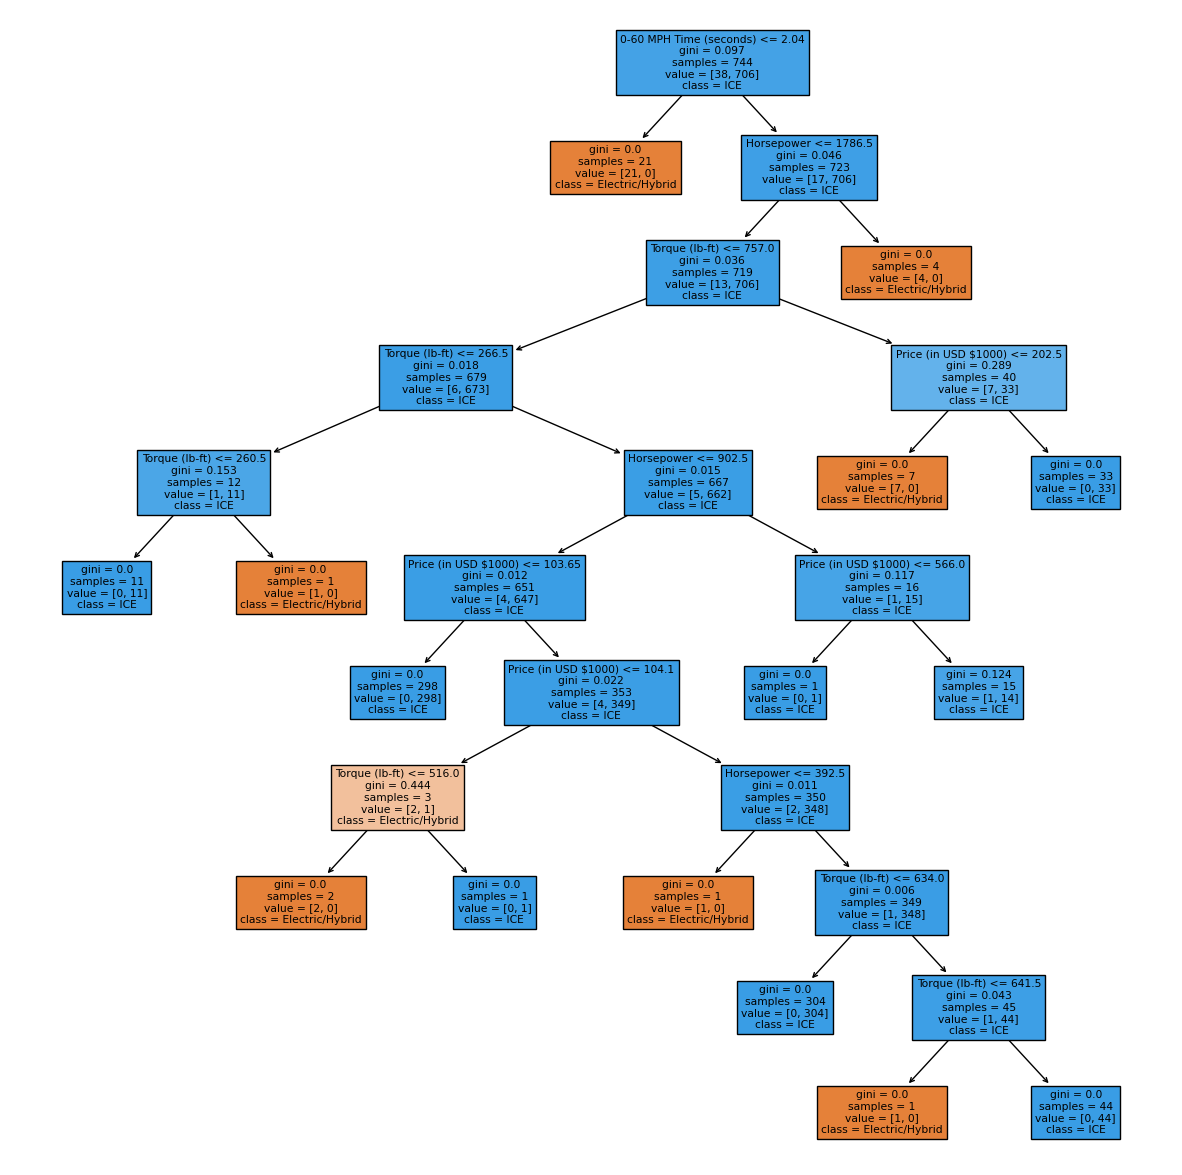

In [37]:
plt.figure(figsize=(15, 15))
tree.plot_tree(clsmod, filled=True, feature_names=X1.keys(), class_names=clsmod.classes_)
plt.show()

In [38]:
clsmod_ent = DecisionTreeClassifier(random_state=0, criterion='entropy')
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)
clsmod_ent.fit(X1_train, y1_train)
print(f'levels of depth: {clsmod_ent.get_depth()}')
print(f'Train score: {clsmod_ent.score(X1_train, y1_train)} ,Test score: {clsmod_ent.score(X1_test, y1_test)}')
y1_predic_engine = clsmod.predict(X1_test)
print(f'Accuracy : {accuracy_score(y1_test,y1_predic_engine)}')

levels of depth: 8
Train score: 0.9986559139784946 ,Test score: 0.9879518072289156
Accuracy : 0.9919678714859438


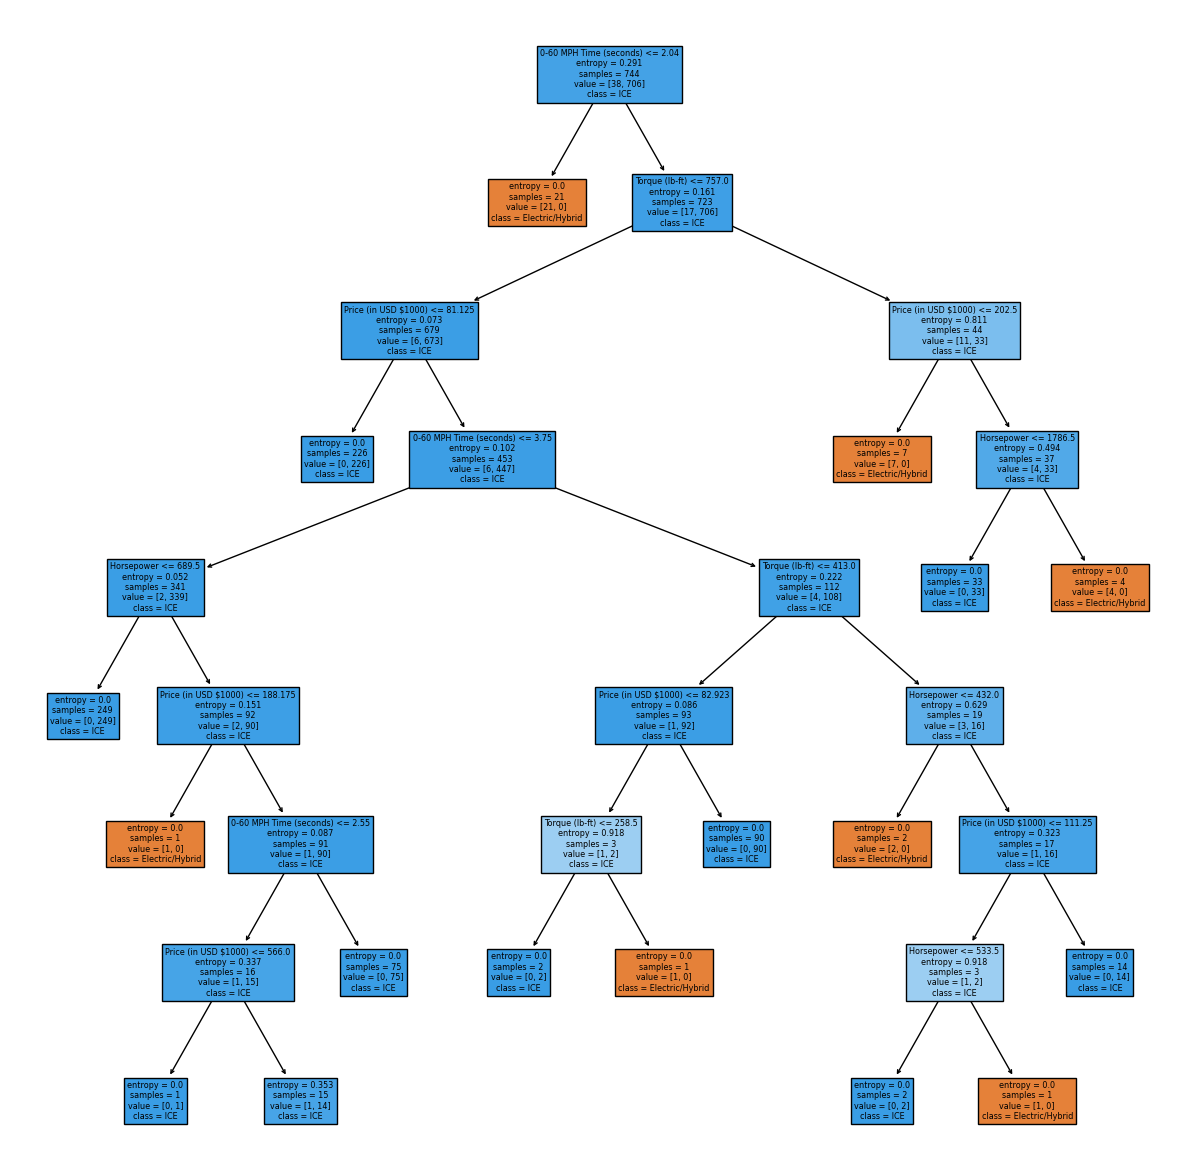

In [39]:
plt.figure(figsize=(15, 15))
tree.plot_tree(clsmod_ent, filled=True, feature_names=clsmod_ent.feature_names_in_, class_names=clsmod_ent.classes_)
plt.show()